<a href="https://colab.research.google.com/github/arpan0003/ml-projet.2/blob/main/emotion_recognition_lstm_93_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [ ]:
# Text preprocessing function

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text

In [ ]:
# Read dataset & Preprocess text
# dataset = pd.read_csv('../input/isear-emotion/isear_dataset.csv')
df_train = pd.read_csv('train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

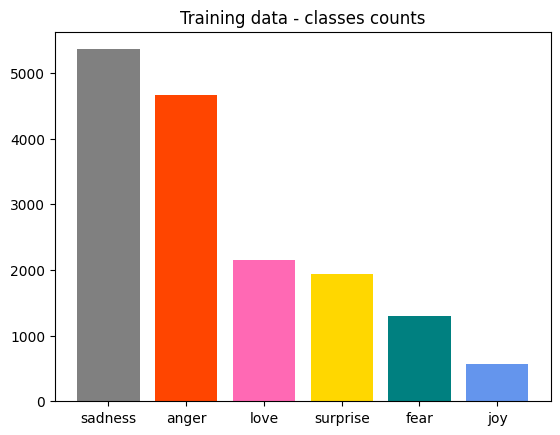

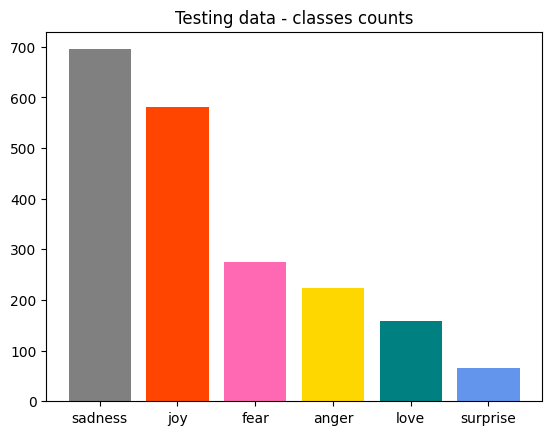

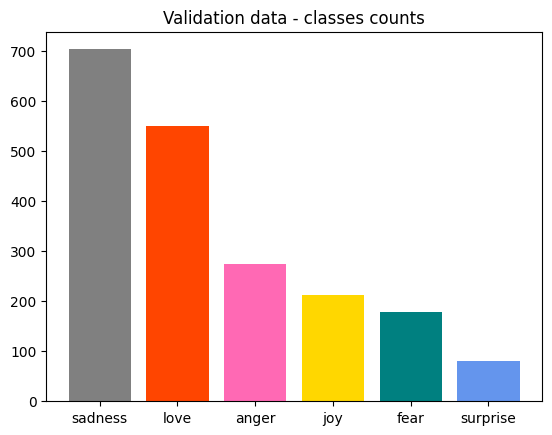

In [ ]:
# Visualize classes counts
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

plt.bar(y_train.unique(),height=y_train.value_counts(), color=colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(y_test.unique(),height=y_test.value_counts(), color=colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(y_val.unique(),height=y_val.value_counts(), color=colors)
plt.title("Validation data - classes counts")
plt.show()

In [ ]:
# Encode labels

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [ ]:

# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-09-04 11:46:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-09-04 11:46:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-09-04 11:46:22--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Read GloVE embeddings

path_to_glove_file = 'glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15069 words (1115 misses)


In [ ]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          3237000   
                                                                 
 bidirectional (Bidirectiona  (None, 256, 512)         935936    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 256)         656384    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

In [ ]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

In [ ]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=256,
                    epochs=10,
                    callbacks=[callback]
                   )

Epoch 1/10
63/63 [==============================] - 589s 9s/step - loss: 1.5532 - accuracy: 0.3731 - val_loss: 1.3166 - val_accuracy: 0.5325
Epoch 2/10
63/63 [==============================] - 567s 9s/step - loss: 1.1805 - accuracy: 0.5617 - val_loss: 0.9009 - val_accuracy: 0.6825
Epoch 3/10
63/63 [==============================] - 555s 9s/step - loss: 0.6712 - accuracy: 0.7610 - val_loss: 0.4245 - val_accuracy: 0.8585
Epoch 4/10
63/63 [==============================] - 551s 9s/step - loss: 0.3323 - accuracy: 0.8812 - val_loss: 0.2684 - val_accuracy: 0.9010
Epoch 5/10
63/63 [==============================] - 561s 9s/step - loss: 0.2076 - accuracy: 0.9194 - val_loss: 0.2008 - val_accuracy: 0.9170
Epoch 6/10
63/63 [==============================] - 559s 9s/step - loss: 0.1583 - accuracy: 0.9334 - val_loss: 0.2147 - val_accuracy: 0.9095
Epoch 7/10
63/63 [==============================] - 556s 9s/step - loss: 0.1361 - accuracy: 0.9411 - val_loss: 0.1820 - val_accuracy: 0.9150
Epoch 8/10
63

In [ ]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 29s 457ms/step - loss: 0.1536 - accuracy: 0.9235


[0.1536293774843216, 0.9235000014305115]

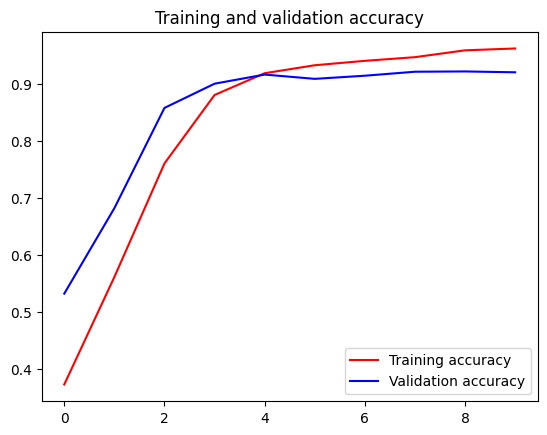

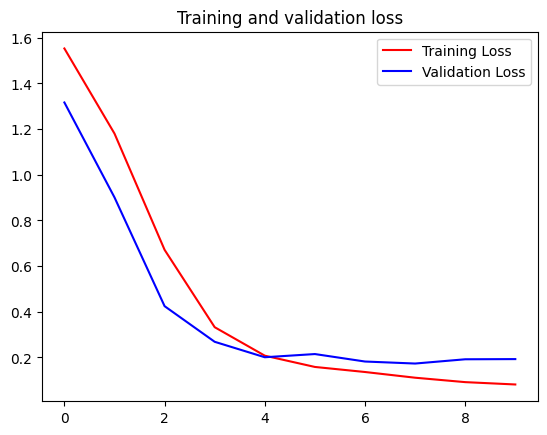

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Classify custom sample

sentences = [
            "He's very excited to get the new book",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

He's very excited to get the new book


NameError: ignored

In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)


model.save('Emotion Recognition.h5')